# RetinaNet Object Detection

## Imports

In [1]:
import matplotlib
import matplotlib.pyplot as plt

import os
import sys
import random
import io
import imageio
import glob
import scipy.misc
import numpy as np
import math
import imutils
import cv2
import pandas as pd
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_graphics as tfg
import tensorflow_graphics.geometry.transformation as tfg_transformation

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

%matplotlib inline

print("Done")

Done


## Load the dataset

In [3]:
(ds_train, ds_val, ds_test), ds_info = tfds.load("bee_dataset/bee_dataset_150",
                                                 split=["train[0%:70%]", "train[70%:85%]", "train[85%:100%]"],
                                                 shuffle_files=False,
                                                 as_supervised=True,
                                                 with_info=True)
category_index = {1: {'id': 1, 'name': 'cooling'}, 2: {'id': 1, 'name': 'pollen'}, 3: {'id': 1, 'name': 'varroa'}, 4: {'id': 1, 'name': 'wasps'}}
names_list = []
for names in list(category_index.values()):
    names_list.append(names['name'])
print(names_list)

print("Training set: {}, Validation set: {}, Test set: {}".format(len(list(ds_train)), len(list(ds_val)), len(list(ds_test))))

['cooling', 'pollen', 'varroa', 'wasps']
Training set: 5243, Validation set: 1123, Test set: 1124


## Legacy Utilities

In [4]:
def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None):
  """Wrapper function to visualize detections.

  Args:
    image_np: uint8 numpy array with shape (img_height, img_width, 3)
    boxes: a numpy array of shape [N, 4]
    classes: a numpy array of shape [N]. Note that class indices are 1-based,
      and match the keys in the label map.
    scores: a numpy array of shape [N] or None.  If scores=None, then
      this function assumes that the boxes to be plotted are groundtruth
      boxes and plot all boxes as black with no classes or scores.
    category_index: a dict containing category dictionaries (each holding
      category index `id` and category name `name`) keyed by category indices.
    figsize: size for the figure.
    image_name: a name for the image file.
  """
  image_np_with_annotations = image_np.copy()
  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_annotations,
      boxes,
      classes,
      scores,
      category_index,
      use_normalized_coordinates=True,
      min_score_thresh=0.8)
  if image_name:
    plt.imsave(image_name, image_np_with_annotations)
  else:
    plt.imshow(image_np_with_annotations)

print("Done")

Done


## New Utilities

In [21]:
def extract_sub(ds_entry):
    new_image = np.array(ds_entry[0])
    label = tfds.as_numpy(ds_entry[1].values())

    t_lower = 0 # Lower Threshold
    t_upper = 150 # Upper threshold (higher yields less detail)
    aperture_size = 3 # Aperture size (default = 3)
    L2Gradient = False # Boolean (default = False)
    edges = cv2.Canny(new_image, t_lower, t_upper, apertureSize = aperture_size, L2gradient = L2Gradient)
    w = int(list(tf.shape(new_image))[1]) #len(new_image[0])
    h = int(list(tf.shape(new_image))[0])
    ymin = h
    xmin = w
    ymax = 0
    xmax = 0
    coords = [ymin, xmin, ymax, xmax]
    
    # Find left bound/xmin
    left_bound = np.zeros([h, w])
    row_track = 0
    while row_track < h:
        column_track = 0
        while column_track < w:
            value = edges[row_track, column_track]
            if (value > 0):
                left_bound[row_track][column_track: w - 1] = 1
                if (column_track < coords[1]):
                    coords[1] = column_track
                w = w
                break
            elif (column_track == w-1) & (value == 0):
                w = w
                break
            column_track = column_track + 1
        row_track = row_track + 1

    # Find right bound/xmax
    right_bound = np.zeros([h, w])
    row_track = 0
    while row_track < h:
        column_track = 0
        while column_track < w:
            value = edges[row_track, w - 1 - column_track]
            if (value > 0):
                right_bound[row_track][0:w - 1 - column_track] = 1
                if (column_track > coords[3]):
                    coords[3] = column_track
                w = w
                break
            elif (column_track == w-1) & (value == 0):
                w = w
                break
            column_track = column_track + 1
        row_track = row_track + 1

    # Find top bound/ymin
    top_bound = np.zeros([w, h])
    column_track = 0
    while column_track < w:
        row_track = 0
        while row_track < h:
            value = edges[row_track, column_track]
            if (value > 0):
                top_bound[column_track][row_track:h-1] = 1
                if (row_track < coords[0]):
                    print(row_track, value)
                    coords[0] = row_track
                h = h
                break
            elif (row_track == h-1) & (value == 0):
                h = h
                break
            row_track = row_track + 1
        column_track = column_track + 1
    top_bound = np.transpose(top_bound)

    # Find bottom bound/ymax
    bottom_bound = np.zeros([w, h])
    column_track = 0
    while column_track < w:
        row_track = 0
        while row_track < h:
            value = edges[h - 1 - row_track, column_track]
            if (value > 0):
                bottom_bound[column_track][0:h - 1 - row_track] = 1
                if (row_track > coords[2]):
                    coords[2] = row_track
                h = h
                break
            elif (row_track == h-1) & (value == 0):
                h = h
                break
            row_track = row_track + 1
        column_track = column_track + 1
    bottom_bound = np.transpose(bottom_bound)
    print(coords)
    
    mask = top_bound * bottom_bound * right_bound * left_bound
    mask = cv2.GaussianBlur(mask,(5,5),cv2.BORDER_DEFAULT)
    mask = np.repeat(mask[:, :, np.newaxis], 3, axis=2)
    #new_image = tf.image.stateless_random_brightness(new_image, 0.99, seed=(1, 2))
    #new_image = tf.image.stateless_random_contrast(new_image, 0.9, 1, seed=(1, 2))
    new_image = new_image * mask
    #new_image = new_image.numpy()
    new_image = new_image.astype(np.uint8)
    
    return new_image, label, coords

'''
def extract_coords(image, current_coords):
    [ymin, xmin, ymax, xmax] = current_coords * 640
    ymin = int(ymin)
    xmin = int(xmin)
    ymax = int(ymax)
    xmax = int(xmax)
    new_image = np.array(image).astype(np.uint8)
    t_lower = 0 # Lower Threshold
    t_upper = 150 # Upper threshold (higher yields less detail)
    aperture_size = 3 # Aperture size (default = 3)
    L2Gradient = False # Boolean (default = False)
    edges = cv2.Canny(new_image, t_lower, t_upper, apertureSize = aperture_size, L2gradient = L2Gradient)
    w = list(tf.shape(new_image))[1] #len(new_image[0])
    h = list(tf.shape(new_image))[0]

    coords = [640, 640, 0, 0]
    # Find xmin
    print("Finding xmin")
    row_track = ymin
    while row_track < ymax:
        column_track = xmin
        while column_track < xmax:
            value = edges[row_track, column_track]
            if (value > 0) & (column_track < coords[1]):
                coords[1] = column_track
                w = w
                break
            elif (column_track == w-1) & (value == 0):
                w = w
                break
            column_track = column_track + 1
        row_track = row_track + 1
        print(row_track)
    print("Previous xmin: {}, New xmin: {}", current_coords[1], coords[1])

    # Find xmax
    print("Finding xmax")
    row_track = ymin
    while row_track < ymax:
        column_track = xmin
        while column_track < xmax:
            value = edges[row_track, w - 1 - column_track]
            if (value > 0) & (column_track > coords[3]):
                coords[3] = column_track
                w = w
                break
            elif (column_track == w-1) & (value == 0):
                w = w
                break
            column_track = column_track + 1
        row_track = row_track + 1
        print(row_track)
    print("Previous xmax: {}, New xmax: {}", current_coords[3], coords[3])

    # Find ymin
    print("Finding ymin")
    column_track = xmin
    while column_track < xmax:
        row_track = ymin
        while row_track < ymax:
            value = edges[row_track, column_track]
            if (value > 0) & (row_track > coords[0]):
                coords[0] = row_track
                h = h
                break
            elif (row_track == h-1) & (value == 0):
                h = h
                break
            row_track = row_track + 1
        column_track = column_track + 1
        print(column_track)
    print("Previous ymin: {}, New ymin: {}", current_coords[2], coords[2])

    # Find ymax
    print("Finding ymax")
    column_track = xmin
    while column_track < xmax:
        row_track = ymin
        while row_track < ymax:
            value = edges[h - 1 - row_track, column_track]
            if (value > 0) & (row_track < coords[2]):
                coords[2] = row_track
                h = h
                break
            elif (row_track == h-1) & (value == 0):
                h = h
                break
            row_track = row_track + 1
        column_track = column_track + 1
        print(column_track)
    coords = np.array([(i / 640) for i in coords])
    print("Previous ymax: {}, New ymax: {}", current_coords[0], coords[0])
    
    return coords
'''

def extract_coords(image, current_coords):
    [ymin, xmin, ymax, xmax] = current_coords * 640
    ymin = int(ymin)
    xmin = int(xmin)
    ymax = int(ymax)
    xmax = int(xmax)
    print(ymin, xmin, ymax, xmax)
    new_image = np.array(image).astype(np.uint8)
    t_lower = 0 # Lower Threshold
    t_upper = 150 # Upper threshold (higher yields less detail)
    aperture_size = 3 # Aperture size (default = 3)
    L2Gradient = False # Boolean (default = False)
    edges = cv2.Canny(new_image, t_lower, t_upper, apertureSize = aperture_size, L2gradient = L2Gradient)
    plt.imshow(edges)
    plt.show()
    w = int(list(tf.shape(new_image))[1]) #len(new_image[0])
    h = int(list(tf.shape(new_image))[0])
    coords = [h, w, 0, 0]
    
    # Find xmin
    row_track = ymin
    while row_track < ymax:
        column_track = xmin
        while column_track < xmax:
            value = edges[row_track, column_track]
            if (value > 0):
                print(value)
                print(column_track)
                if (column_track < coords[1]):
                    coords[1] = column_track
                w = w
                break
            elif (column_track == w-1) & (value == 0):
                w = w
                break
            column_track = column_track + 1
        row_track = row_track + 1

    # Find xmax
    row_track = ymin
    while row_track < ymax:
        column_track = xmin
        while column_track < xmax:
            value = edges[row_track, w - 1 - column_track]
            if (value > 0):
                if (column_track > coords[3]):
                    coords[3] = column_track
                w = w
                break
            elif (column_track == w-1) & (value == 0):
                w = w
                break
            column_track = column_track + 1
        row_track = row_track + 1

    # Find y
    column_track = xmin
    while column_track < xmax:
        row_track = ymin
        while row_track < ymax:
            value = edges[row_track, column_track]
            if (value > 0):
                if (row_track > coords[0]):
                    coords[0] = row_track
                    print(coords[0])
                h = h
                break
            elif (row_track == h-1) & (value == 0):
                h = h
                break
            row_track = row_track + 1
        column_track = column_track + 1

    # Find y
    column_track = xmin
    while column_track < xmax:
        row_track = ymin
        while row_track < ymax:
            value = edges[h - 1 - row_track, column_track]
            if (value > 0):
                if (row_track < coords[2]):
                    coords[2] = row_track
                    print(coords[2])
                h = h
                break
            elif (row_track == h-1) & (value == 0):
                h = h
                break
            row_track = row_track + 1
        column_track = column_track + 1

    print(coords)
    coords = np.array([(i / 640) for i in coords])
    
    return coords

print("Done")

Done


## Data Augmentation

In [26]:
def process_image(new_image, label, coords):
    
    new_image = tf.expand_dims(new_image, 0)

    DataGen = ImageDataGenerator(width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

    # because as we already load image into the memory, so we are using flow() function, to apply transformation
    iterator = DataGen.flow(new_image, batch_size=1)
    # generating images of each batch
    batch = iterator.next()
    # again we convert back to the unsigned integers value of the image for viewing
    new_image = batch[0].astype('uint8')
    #coords relative to center of box so as to not multiply 0
    
    rotation_range=random.uniform(0, 360)
    new_image = imutils.rotate_bound(new_image, rotation_range)
    coords = imutils.rotate_bound(coords, rotation_range)
    #coords = [0, 0, tf.shape(new_image)[0], tf.shape(new_image)[1]]
    
    trans_label = []
    j = 1
    while j <= len(label):
        trans_label.append(label[j-1]*j)
        j = j + 1
    trans_label = np.array(int(np.sum(trans_label)))
    
    x_offset = tf.random.uniform((), 0 , tf.cast(640-(list(tf.shape(new_image))[1]), tf.int32), dtype=tf.int32)
    y_offset = tf.random.uniform((), 0 , tf.cast(640-(list(tf.shape(new_image))[0]), tf.int32), dtype=tf.int32)
    
    new_image = tf.reshape(new_image, (list(tf.shape(new_image))[0],list(tf.shape(new_image))[1],3))
    new_image = tf.image.pad_to_bounding_box(new_image, y_offset, x_offset, 640, 640)
    new_image = tf.cast(new_image, tf.float32)/255.0

    coord_adder = [y_offset, x_offset, y_offset, x_offset]
    coords = np.array([sum(i) for i in zip(coords, coord_adder)])
    coords = np.array([(i / 640) for i in coords])
    print(coords)
    return new_image, label, coords

print("Done")

Done


In [27]:
new_image, label, coords = extract_sub(list(ds_train)[np.random.randint(0, 5242)])
image, label, coords = process_image(new_image, label, coords)

colors = np.array([[1.0, 0.0, 0.0], [0.0, 0.0, 1.0]])
#coords = extract_coords(image, coords)
image = tf.image.draw_bounding_boxes(tf.expand_dims(image, axis=0), tf.reshape(tf.cast(coords, tf.float32),[1, 1, 4]), colors)

plt.imshow(tf.squeeze(image))
plt.show()

43 255
36 255
35 255
29 255
4 255
[4, 0, 86, 71]


AttributeError: 'list' object has no attribute 'shape'

# Prepare data for training

Below we add the class annotations (for simplicity, we assume a single class in this colab; though it should be straightforward to extend this to handle multiple classes).  We also convert everything to the format that the training
loop below expects (e.g., everything converted to tensors, classes converted to one-hot representations, etc.).

In [250]:
# By convention, our non-background classes start counting at 1.
num_classes = 5

# Convert class labels to one-hot; convert everything to tensors.
# The `label_id_offset` here shifts all classes by a certain number of indices;
# we do this here so that the model receives one-hot labels where non-background
# classes start counting at the zeroth index.  This is ordinarily just handled
# automatically in our training binaries, but we need to reproduce it here.
label_id_offset = 1
train_image_tensors = []
gt_classes_one_hot_tensors = []
gt_box_tensors = []
for (train_image_np, gt_box_np) in zip(
    train_images_np, gt_boxes):
  train_image_tensors.append(tf.expand_dims(tf.convert_to_tensor(
      train_image_np, dtype=tf.float32), axis=0))
  gt_box_tensors.append(tf.convert_to_tensor(gt_box_np, dtype=tf.float32))
  zero_indexed_groundtruth_classes = tf.convert_to_tensor(
      np.ones(shape=[gt_box_np.shape[0]], dtype=np.int32) - label_id_offset)
  gt_classes_one_hot_tensors.append(tf.one_hot(
      zero_indexed_groundtruth_classes, num_classes))
print('Done prepping data.')

Done prepping data.


# Let's just visualize the bees as a sanity check


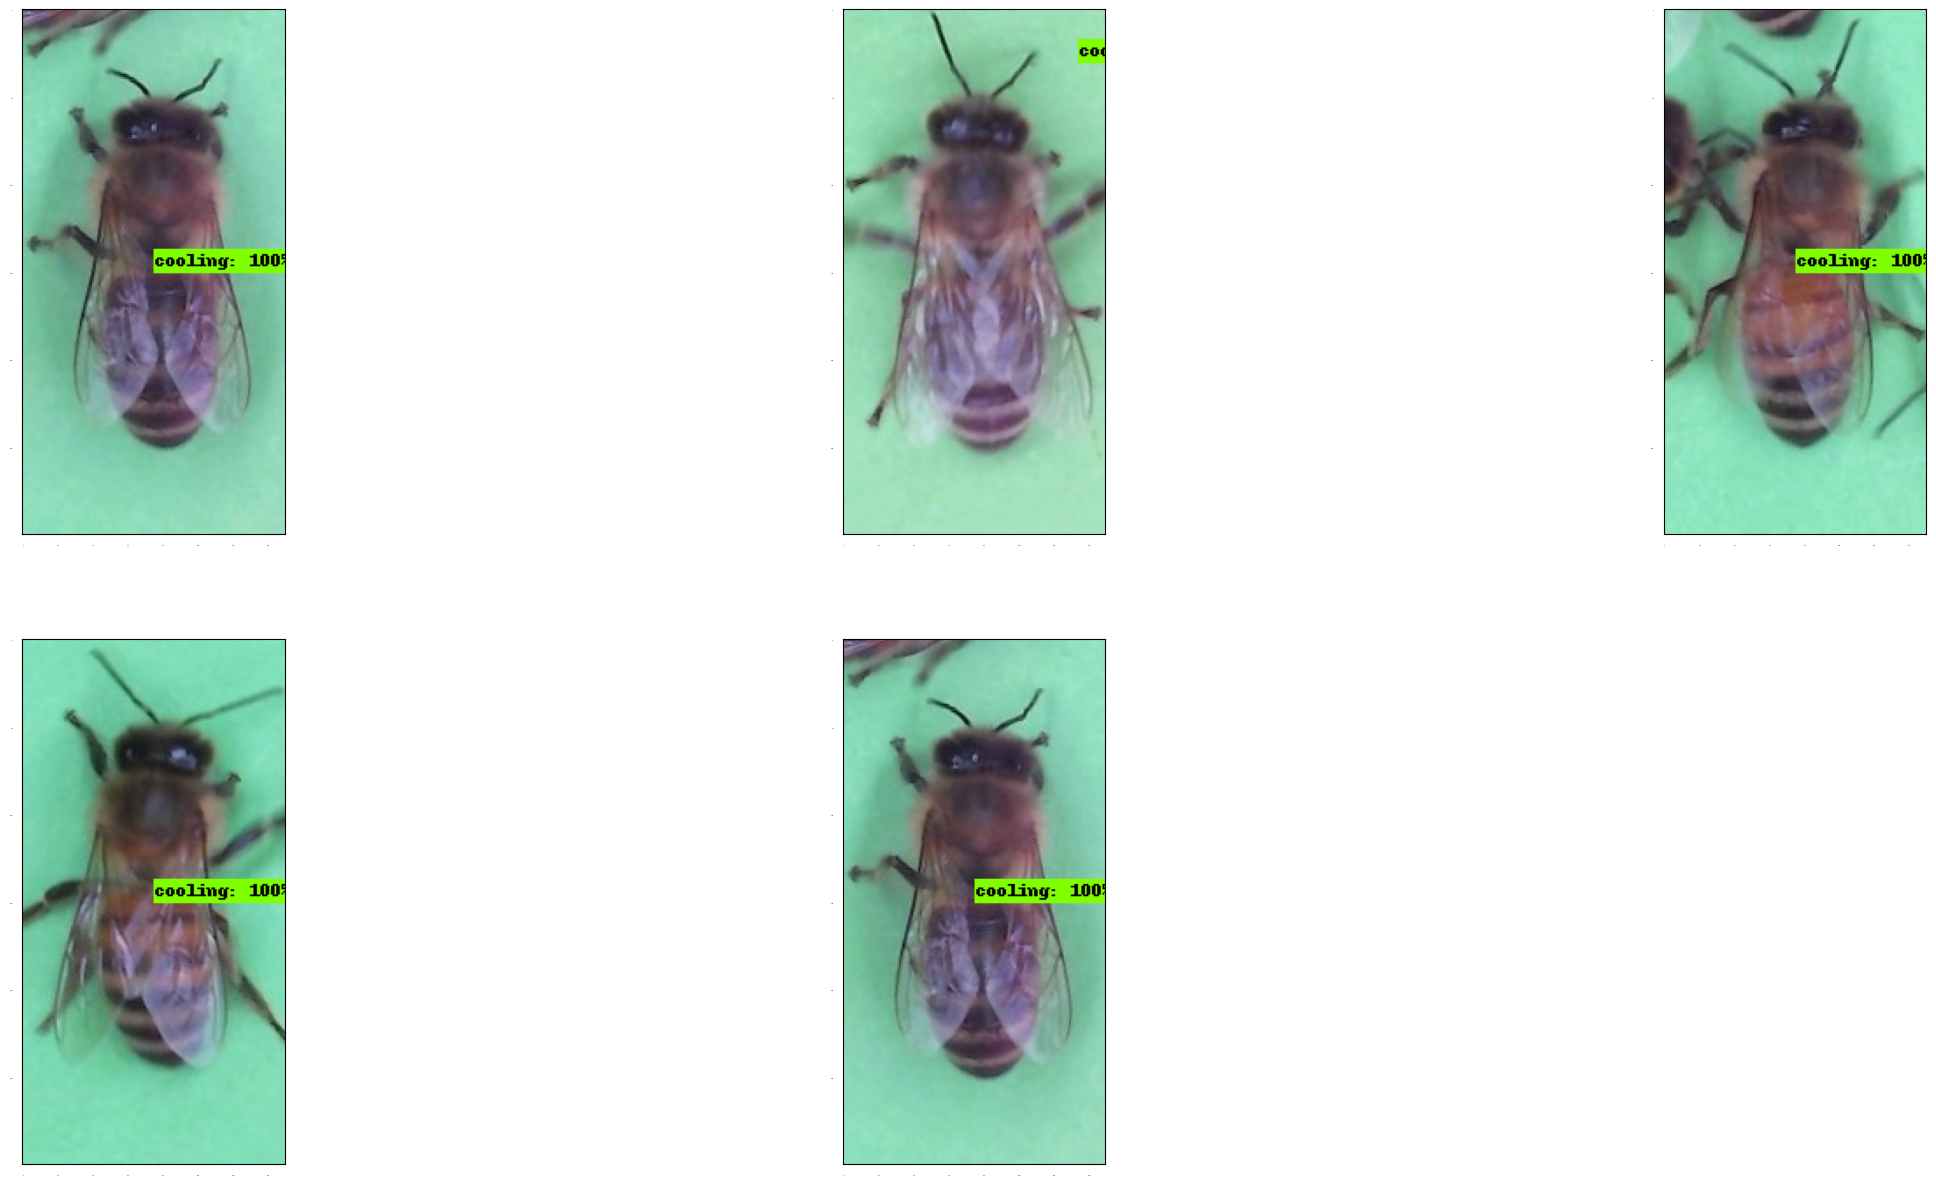

[[[156 224 185]
  [155 223 184]
  [155 223 184]
  ...
  [161 228 185]
  [162 229 186]
  [163 230 187]]

 [[155 223 184]
  [155 223 184]
  [155 223 184]
  ...
  [160 227 184]
  [160 227 184]
  [161 228 185]]

 [[152 223 181]
  [153 224 182]
  [153 224 182]
  ...
  [160 227 184]
  [159 226 183]
  [159 226 183]]

 ...

 [[162 226 191]
  [162 226 191]
  [162 226 191]
  ...
  [167 229 190]
  [167 229 190]
  [167 229 190]]

 [[161 227 191]
  [161 227 191]
  [162 226 191]
  ...
  [165 230 190]
  [165 230 190]
  [164 229 189]]

 [[161 227 191]
  [161 227 191]
  [162 226 191]
  ...
  [165 230 190]
  [165 230 190]
  [164 229 189]]]
[[0.1 0.9 0.1 0.9]]
[1]
[1.]
{1: {'id': 1, 'name': 'cooling'}, 2: {'id': 1, 'name': 'pollen'}, 3: {'id': 1, 'name': 'varroa'}, 4: {'id': 1, 'name': 'wasps'}}
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'dict'>


In [251]:
dummy_scores2 = np.array([1.0], dtype=np.float32)  # give boxes a score of 100%

plt.figure(figsize=(30, 15))
for idx in range(5):
  plt.subplot(2, 3, idx+1)
  plot_detections(
      train_images_np[idx-1],
      gt_boxes[idx-1],
      np.ones(shape=[gt_boxes[idx-1].shape[0]], dtype=np.int32),
      dummy_scores2, category_index)
plt.show()

print(train_images_np[0])
print(gt_boxes[0])
print(np.ones(shape=[gt_boxes[0].shape[0]], dtype=np.int32))
print(dummy_scores2)
print(category_index)
print(type(train_images_np[0]))
print(type(gt_boxes[0]))
print(type(np.ones(shape=[gt_boxes[0].shape[0]], dtype=np.int32)))
print(type(dummy_scores2))
print(type(category_index))

# Create model and restore weights for all but last layer

In this cell we build a single stage detection architecture (RetinaNet) and restore all but the classification layer at the top (which will be automatically randomly initialized).

For simplicity, we have hardcoded a number of things in this colab for the specific RetinaNet architecture at hand (including assuming that the image size will always be 640x640), however it is not difficult to generalize to other model configurations.

In [30]:
tf.keras.backend.clear_session()

print('Building model and restoring weights for fine-tuning...', flush=True)
num_classes = 5
pipeline_config = '/home/kevinhardin/Documents/Tensorflow/models/research/object_detection/configs/tf2/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.config'
checkpoint_path = '/home/kevinhardin/Documents/Tensorflow/models/research/object_detection/test_data/checkpoint/ckpt-0'

# Load pipeline config and build a detection model.
#
# Since we are working off of a COCO architecture which predicts 90
# class slots by default, we override the `num_classes` field here to be just
# one (for our new rubber ducky class).
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
model_config.ssd.num_classes = num_classes
model_config.ssd.freeze_batchnorm = True
detection_model = model_builder.build(
      model_config=model_config, is_training=True)

# Set up object-based checkpoint restore --- RetinaNet has two prediction
# `heads` --- one for classification, the other for box regression.  We will
# restore the box regression head but initialize the classification head
# from scratch (we show the omission below by commenting out the line that
# we would add if we wanted to restore both heads)
fake_box_predictor = tf.compat.v2.train.Checkpoint(
    _base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads,
    # _prediction_heads=detection_model._box_predictor._prediction_heads,
    #    (i.e., the classification head that we *will not* restore)
    _box_prediction_head=detection_model._box_predictor._box_prediction_head,
    )
fake_model = tf.compat.v2.train.Checkpoint(
          _feature_extractor=detection_model._feature_extractor,
          _box_predictor=fake_box_predictor)
ckpt = tf.compat.v2.train.Checkpoint(model=fake_model)
ckpt.restore(checkpoint_path).expect_partial()

# Run model through a dummy image so that variables are created
image, shapes = detection_model.preprocess(tf.zeros([1, 640, 640, 3]))
prediction_dict = detection_model.predict(image, shapes)
_ = detection_model.postprocess(prediction_dict, shapes)
print('Weights restored!')

Building model and restoring weights for fine-tuning...
Weights restored!


# Eager mode custom training loop



In [ ]:
tf.keras.backend.set_learning_phase(True)

# These parameters can be tuned; since our training set has 5 images
# it doesn't make sense to have a much larger batch size, though we could
# fit more examples in memory if we wanted to.
batch_size = 4
learning_rate = 0.01
num_batches = 100

# Select variables in top layers to fine-tune.
trainable_variables = detection_model.trainable_variables
to_fine_tune = []
prefixes_to_train = [
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead']
for var in trainable_variables:
  if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
    to_fine_tune.append(var)

# Set up forward + backward pass for a single train step.
def get_model_train_step_function(model, optimizer, vars_to_fine_tune):
  """Get a tf.function for training step."""

  # Use tf.function for a bit of speed.
  # Comment out the tf.function decorator if you want the inside of the
  # function to run eagerly.
  #@tf.function
  def train_step_fn(image_tensors,
                    groundtruth_boxes_list,
                    groundtruth_classes_list):
    """A single training iteration.

    Args:
      image_tensors: A list of [1, height, width, 3] Tensor of type tf.float32.
        Note that the height and width can vary across images, as they are
        reshaped within this function to be 640x640.
      groundtruth_boxes_list: A list of Tensors of shape [N_i, 4] with type
        tf.float32 representing groundtruth boxes for each image in the batch.
      groundtruth_classes_list: A list of Tensors of shape [N_i, num_classes]
        with type tf.float32 representing groundtruth boxes for each image in
        the batch.

    Returns:
      A scalar tensor representing the total loss for the input batch.
    """
    shapes = tf.constant(batch_size * [[640, 640, 3]], dtype=tf.int32)
    model.provide_groundtruth(
        groundtruth_boxes_list=groundtruth_boxes_list,
        groundtruth_classes_list=groundtruth_classes_list)
    with tf.GradientTape() as tape:
      preprocessed_images = tf.concat(
          [detection_model.preprocess(image_tensor)[0]
           for image_tensor in image_tensors], axis=0)
      prediction_dict = model.predict(preprocessed_images, shapes)
      losses_dict = model.loss(prediction_dict, shapes)
      total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']
      gradients = tape.gradient(total_loss, vars_to_fine_tune)
      optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))
    return total_loss

  return train_step_fn

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
train_step_fn = get_model_train_step_function(
    detection_model, optimizer, to_fine_tune)

print('Start fine-tuning!', flush=True)
for idx in range(num_batches):
  # Grab keys for a random subset of examples
  all_keys = list(range(len(train_images_np)))
  random.shuffle(all_keys)
  example_keys = all_keys[:batch_size]

  # Note that we do not do data augmentation in this demo.  If you want a
  # a fun exercise, we recommend experimenting with random horizontal flipping
  # and random cropping :)
  gt_boxes_list = [gt_box_tensors[key] for key in example_keys]
  gt_classes_list = [gt_classes_one_hot_tensors[key] for key in example_keys]
  image_tensors = [train_image_tensors[key] for key in example_keys]

  # Training step (forward pass + backwards pass)
  total_loss = train_step_fn(image_tensors, gt_boxes_list, gt_classes_list)

  if idx % 10 == 0:
    print('batch ' + str(idx) + ' of ' + str(num_batches)
    + ', loss=' +  str(total_loss.numpy()), flush=True)

print('Done fine-tuning!')

Start fine-tuning!


# Load test images and run inference with new model!

In [ ]:
test_image_dir = 'models/research/object_detection/test_images/ducky/test/'
test_images_np = []
for i in range(1, 50):
  image_path = os.path.join(test_image_dir, 'out' + str(i) + '.jpg')
  test_images_np.append(np.expand_dims(
      load_image_into_numpy_array(image_path), axis=0))

# Again, comment this decorator if you want to run inference eagerly
#@tf.function
def detect(input_tensor):
  """Run detection on an input image.

  Args:
    input_tensor: A [1, height, width, 3] Tensor of type tf.float32.
      Note that height and width can be anything since the image will be
      immediately resized according to the needs of the model within this
      function.

  Returns:
    A dict containing 3 Tensors (`detection_boxes`, `detection_classes`,
      and `detection_scores`).
  """
  preprocessed_image, shapes = detection_model.preprocess(input_tensor)
  prediction_dict = detection_model.predict(preprocessed_image, shapes)
  return detection_model.postprocess(prediction_dict, shapes)

# Note that the first frame will trigger tracing of the tf.function, which will
# take some time, after which inference should be fast.

label_id_offset = 1
for i in range(len(test_images_np)):
  input_tensor = tf.convert_to_tensor(test_images_np[i], dtype=tf.float32)
  detections = detect(input_tensor)

  plot_detections(
      test_images_np[i][0],
      detections['detection_boxes'][0].numpy(),
      detections['detection_classes'][0].numpy().astype(np.uint32)
      + label_id_offset,
      detections['detection_scores'][0].numpy(),
      category_index, figsize=(15, 20), image_name="gif_frame_" + ('%02d' % i) + ".jpg")

In [ ]:
imageio.plugins.freeimage.download()

anim_file = 'duckies_test.gif'

filenames = glob.glob('gif_frame_*.jpg')
filenames = sorted(filenames)
last = -1
images = []
for filename in filenames:
  image = imageio.imread(filename)
  images.append(image)

imageio.mimsave(anim_file, images, 'GIF-FI', fps=5)

display(IPyImage(open(anim_file, 'rb').read()))